In [1]:
!git clone https://github.com/leongatys/PytorchNeuralStyleTransfer.git

Cloning into 'PytorchNeuralStyleTransfer'...
remote: Enumerating objects: 27, done.
remote: Total 27 (delta 0), reused 0 (delta 0), pack-reused 27
Unpacking objects: 100% (27/27), 2.37 MiB | 2.47 MiB/s, done.


In [2]:
%cd /kaggle/working/PytorchNeuralStyleTransfer

/kaggle/working/PytorchNeuralStyleTransfer


In [3]:
#!sh download_models.sh

In [4]:
%pylab inline
import time
import os 
image_dir = os.getcwd() + '/Images/'
model_dir = os.getcwd() + '/Models/'

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision
from torchvision import transforms

from PIL import Image
from collections import OrderedDict


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [5]:
# Define your VGG model using the standard VGG provided by PyTorch
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.vgg = torch.hub.load('pytorch/vision:v0.9.0', 'vgg19', pretrained=True).features

    def forward(self, x, out_keys):
        out = {}
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in out_keys:
                out[name] = x
        return [out[key] for key in out_keys]

In [6]:
# gram matrix and loss
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1,2)) 
        G.div_(h*w)
        return G

class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target)
        return(out)

In [7]:
# pre and post processing for images
img_size = 512 
prep = transforms.Compose([transforms.Resize(img_size),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),
                          ])
postpa = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),
                           transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to RGB
                           ])
postpb = transforms.Compose([transforms.ToPILImage()])
def postp(tensor): # to clip results in the range [0,1]
    t = postpa(tensor)
    t[t>1] = 1    
    t[t<0] = 0
    img = postpb(t)
    return img

In [8]:
#get network
vgg = VGG()
for param in vgg.parameters():
    param.requires_grad = False
if torch.cuda.is_available():
    vgg.cuda()

Downloading: "https://github.com/pytorch/vision/zipball/v0.9.0" to /root/.cache/torch/hub/v0.9.0.zip
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 175MB/s]  


In [9]:
#load images, ordered as [style_image, content_image]
img_dirs = [image_dir, image_dir]
img_names = ['vangogh_starry_night.jpg', 'Tuebingen_Neckarfront.jpg']
imgs = [Image.open(img_dirs[i] + name) for i,name in enumerate(img_names)]
imgs_torch = [prep(img) for img in imgs]
if torch.cuda.is_available():
    imgs_torch = [Variable(img.unsqueeze(0).cuda()) for img in imgs_torch]
else:
    imgs_torch = [Variable(img.unsqueeze(0)) for img in imgs_torch]
style_image, content_image = imgs_torch

# opt_img = Variable(torch.randn(content_image.size()).type_as(content_image.data), requires_grad=True) #random init
opt_img = Variable(content_image.data.clone(), requires_grad=True)

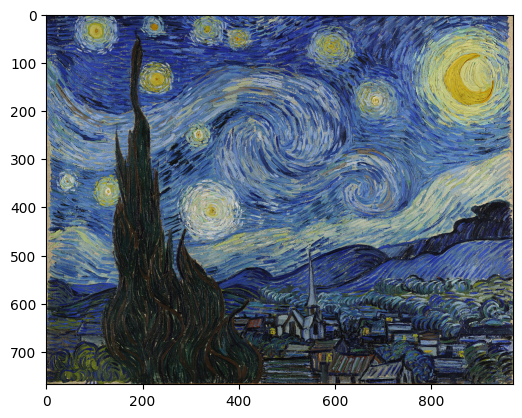

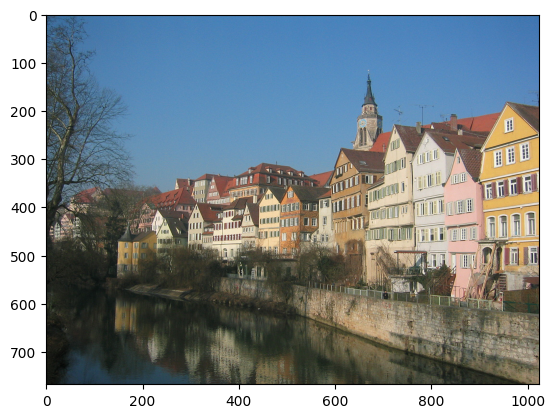

In [10]:
#display images
for img in imgs:
    imshow(img);show()

In [11]:
vgg

VGG(
  (vgg): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(

In [12]:
#define layers, loss functions, weights and compute optimization targets

k_map = {'r11': '1', 'r21': '6',
      'r31' : '11', 'r41' : '20',
      'r51' : '29', 'r42': '22'}

style_layers_name = ['r11','r21','r31','r41', 'r51'] 
style_layers = [k_map[name] for name in style_layers_name]
content_layers = [k_map['r42']]

loss_layers = style_layers + content_layers
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
if torch.cuda.is_available():
    loss_fns = [loss_fn.cuda() for loss_fn in loss_fns]
    
#these are good weights settings:
style_weights = [1e3/n**2 for n in [64,128,256,512,512]]
content_weights = [1e0]
weights = style_weights + content_weights

#compute optimization targets
style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
targets = style_targets + content_targets

Iteration: 50, loss: 8223.306641
Iteration: 100, loss: 5185.052734
Iteration: 150, loss: 4455.870117
Iteration: 200, loss: 4129.049805
Iteration: 250, loss: 3951.849121
Iteration: 300, loss: 3841.298584
Iteration: 350, loss: 3766.184814
Iteration: 400, loss: 3712.459473
Iteration: 450, loss: 3673.323486
Iteration: 500, loss: 3642.366699


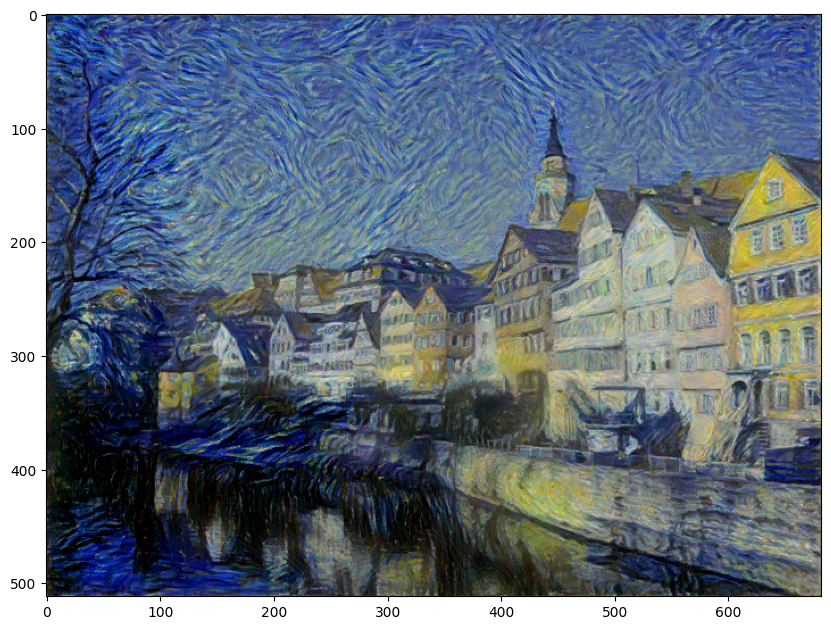

In [13]:
#run style transfer
max_iter = 500
show_iter = 50
optimizer = optim.LBFGS([opt_img]);
n_iter=[0]

while n_iter[0] <= max_iter:

    def closure():
        optimizer.zero_grad()
        out = vgg(opt_img, loss_layers)
        layer_losses = torch.stack([weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)])
        loss = torch.sum(layer_losses)
        loss.backward()
        n_iter[0]+=1
        #print loss
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.item()))
#             print([loss_layers[li] + ': ' +  str(l.data[0]) for li,l in enumerate(layer_losses)]) #loss of each layer
        return loss
    
    optimizer.step(closure)
    
#display result
out_img = postp(opt_img.data[0].cpu().squeeze())
imshow(out_img)
gcf().set_size_inches(10,10)

In [15]:
#make the image high-resolution as described in 
#"Controlling Perceptual Factors in Neural Style Transfer", Gatys et al. 
#(https://arxiv.org/abs/1611.07865)

#hr preprocessing
img_size_hr = 800 #works for 8GB GPU, make larger if you have 12GB or more
prep_hr = transforms.Compose([transforms.Resize(img_size_hr),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),
                          ])
#prep hr images
imgs_torch = [prep_hr(img) for img in imgs]
if torch.cuda.is_available():
    imgs_torch = [Variable(img.unsqueeze(0).cuda()) for img in imgs_torch]
else:
    imgs_torch = [Variable(img.unsqueeze(0)) for img in imgs_torch]
style_image, content_image = imgs_torch

#now initialise with upsampled lowres result
opt_img = prep_hr(out_img).unsqueeze(0)
opt_img = Variable(opt_img.type_as(content_image.data), requires_grad=True)

#compute hr targets
style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
targets = style_targets + content_targets

Iteration: 50, loss: 4346.889160
Iteration: 100, loss: 3377.627930
Iteration: 150, loss: 3051.180420
Iteration: 200, loss: 2889.325195


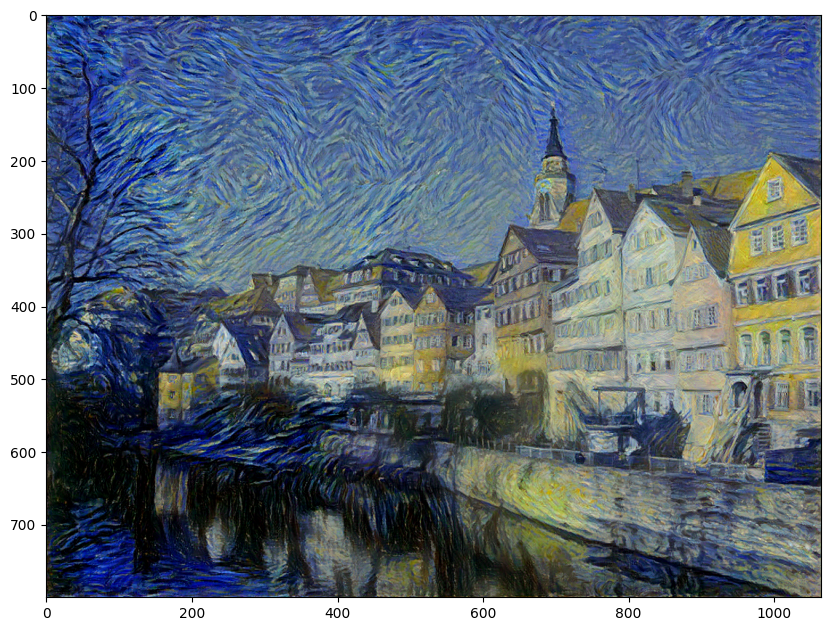

In [17]:
#run style transfer for high res 
max_iter_hr = 200
optimizer = optim.LBFGS([opt_img]);
n_iter=[0]
while n_iter[0] <= max_iter_hr:

    def closure():
        optimizer.zero_grad()
        out = vgg(opt_img, loss_layers)
        layer_losses = torch.stack([weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)])
        loss = torch.sum(layer_losses)
        loss.backward()
        n_iter[0]+=1
        #print loss
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.item()))
#             print([loss_layers[li] + ': ' +  str(l.data[0]) for li,l in enumerate(layer_losses)]) #loss of each layer
        return loss

    optimizer.step(closure)
    
#display result
out_img_hr = postp(opt_img.data[0].cpu().squeeze())
imshow(out_img_hr)
gcf().set_size_inches(10,10)